In [ ]:
!pip install torchvision timm matplotlib seaborn umap-learn scikit-learn
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
drive.mount('/content/my_drive')  # alternative mount point


Mounted at /content/my_drive


In [ ]:
image_dir = '/content/my_drive/MyDrive/archive/wheat_leaf/Healthy'  # Replace with your actual folder


In [ ]:
import glob
image_paths = sorted(glob.glob(os.path.join(image_dir, '**', '*.jpg'), recursive=True) +
                     glob.glob(os.path.join(image_dir, '**', '*.png'), recursive=True))


In [ ]:
class WheatLeafDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.image_paths[idx]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove classification head
resnet.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
def extract_features(dataset):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    all_features, all_paths = [], []
    with torch.no_grad():
        for batch, paths in dataloader:
            features = resnet(batch).squeeze(-1).squeeze(-1).numpy()
            all_features.append(features)
            all_paths.extend(paths)
    return np.vstack(all_features), all_paths

image_dir = '/content/my_drive/MyDrive/archive/wheat_leaf/septoria'
dataset = WheatLeafDataset(image_dir, transform=transform)
features, paths = extract_features(dataset)


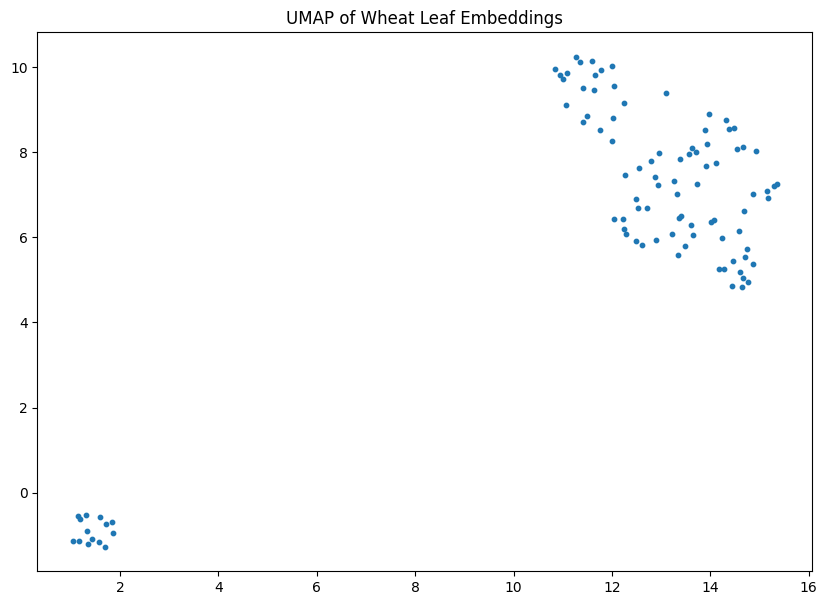

In [ ]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1)
embedding = reducer.fit_transform(features)

plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], s=10)
plt.title("UMAP of Wheat Leaf Embeddings")
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(features)
labels = kmeans.labels_

for i, path in enumerate(paths):
    print(f"{labels[i]} - {os.path.basename(path)}")


0 - los(1).JPG
0 - los(16).JPG
0 - los(15).JPG
0 - los(13).JPG
0 - los(12).JPG
0 - los(11).JPG
0 - los(10).JPG
0 - los(14).JPG
0 - los(3).JPG
0 - los(25).JPG
0 - los(29).JPG
0 - los(17).JPG
0 - los(39).JPG
0 - los(4).JPG
0 - los(28).JPG
0 - los(36).JPG
0 - los(27).JPG
0 - los(33).JPG
0 - los(23).JPG
0 - los(24).JPG
0 - los(35).JPG
0 - los(19).JPG
0 - los(21).JPG
0 - los(32).JPG
0 - los(31).JPG
0 - los(37).JPG
0 - los(22).JPG
0 - los(18).JPG
0 - los(38).JPG
0 - los(20).JPG
0 - los(2).JPG
0 - los(34).JPG
0 - los(30).JPG
0 - los(26).JPG
0 - los(57).JPG
0 - los(54).JPG
0 - los(42).JPG
0 - los(61).JPG
0 - los(44).JPG
0 - los(62).JPG
0 - los(59).JPG
0 - los(49).JPG
0 - los(66).JPG
0 - los(60).JPG
0 - los(63).JPG
0 - los(56).JPG
0 - los(67).JPG
0 - los(50).JPG
0 - los(46).JPG
0 - los(48).JPG
0 - los(45).JPG
0 - los(68).JPG
0 - los(6).JPG
0 - los(41).JPG
0 - los(64).JPG
0 - los(43).JPG
0 - los(51).JPG
0 - los(53).JPG
0 - los(5).JPG
0 - los(55).JPG
0 - los(58).JPG
0 - los(47).JPG
0 - los(40).JP

In [ ]:
import os
import shutil

# ✅ 1. Set destination folder
output_root = '/content/my_drive/MyDrive/archive/wheat_leaf'  # You can change this path

# ✅ 2. Define class folders
class_dirs = {
    0: os.path.join(output_root, 'class_0'),
    1: os.path.join(output_root, 'class_1')
}

# ✅ 3. Create folders if they don't exist
for folder in class_dirs.values():
    os.makedirs(folder, exist_ok=True)

# ✅ 4. Move images based on label
for i, img_path in enumerate(paths):  # 'paths' = list of image file paths
    label = int(labels[i])  # make sure it's an int (0 or 1)
    filename = os.path.basename(img_path)
    dest_path = os.path.join(class_dirs[label], filename)
    shutil.move(img_path, dest_path)  # use .move if you want to delete originals
